In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [33]:
# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Random horizontal flipping
    transforms.RandomRotation(45),  # Random rotation by 45 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [34]:
root_dir = r"D:\pfe_dataset" 
# Load the dataset
dataset = datasets.ImageFolder(root= root_dir, transform=transform)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CBAM (Convolutional Block Attention Module)
class CBAM(nn.Module):
    def __init__(self, channels, reduction_ratio=16):
        super(CBAM, self).__init__()
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction_ratio, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(channels // reduction_ratio, channels, kernel_size=1),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(channels, 1, kernel_size=7, padding=3),
            nn.Sigmoid()
        )

    def forward(self, x):
        channel_attention = self.channel_attention(x)
        x = x * channel_attention
        spatial_attention = self.spatial_attention(x)
        x = x * spatial_attention
        return x

In [36]:
# Define the ECA (Efficient Channel Attention)
class ECA(nn.Module):
    def __init__(self, channels, gamma=2, b=1):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)

In [37]:
# Define the Residual-CE block
class ResidualCE(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualCE, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.cbam = CBAM(out_channels)
        self.eca = ECA(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        out = self.eca(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [38]:
# Define the Inception-ResNet-CE model
class InceptionResNetCE(nn.Module):
    def __init__(self, num_classes=10):
        super(InceptionResNetCE, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualCE(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualCE(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [39]:
# Initialize the model
model = InceptionResNetCE(num_classes=10)

In [40]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [41]:
# Training loop
num_epochs = 70
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/70], Loss: 1.6433715034038463
Epoch [2/70], Loss: 1.453261674718654
Epoch [3/70], Loss: 1.3729761230184676
Epoch [4/70], Loss: 1.3217007352950725
Epoch [5/70], Loss: 1.26324189343351
Epoch [6/70], Loss: 1.1823201572641413
Epoch [7/70], Loss: 1.1367744663928419
Epoch [8/70], Loss: 1.0761358725263717
Epoch [9/70], Loss: 1.02159830991258
Epoch [10/70], Loss: 0.9403806633137642
Epoch [11/70], Loss: 0.895443950561767
Epoch [12/70], Loss: 0.8646003134707188
Epoch [13/70], Loss: 0.7959165991620815
Epoch [14/70], Loss: 0.7633107012890755
Epoch [15/70], Loss: 0.709123395858927
Epoch [16/70], Loss: 0.6851464573373186
Epoch [17/70], Loss: 0.6409661078706701
Epoch [18/70], Loss: 0.6122608964747571
Epoch [19/70], Loss: 0.6033098716685112
Epoch [20/70], Loss: 0.5462427843124309
Epoch [21/70], Loss: 0.5288085677522294
Epoch [22/70], Loss: 0.4907989907771983
Epoch [23/70], Loss: 0.4724623827224082
Epoch [24/70], Loss: 0.45375503092370134
Epoch [25/70], Loss: 0.4533170905519039
Epoch [26/70], 

In [42]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total}%")

Accuracy on test set: 84.4621513944223%


Test Accuracy: 85.13%


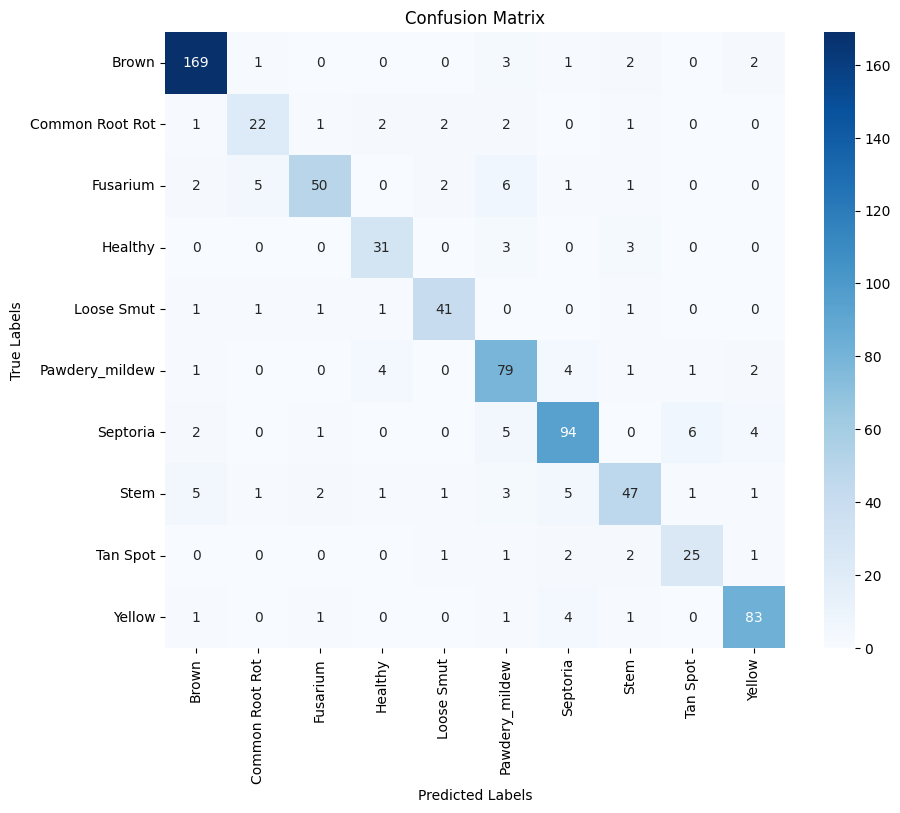

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Evaluate the model on the test set
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [49]:
from sklearn.metrics import classification_report

# Generate classification report
class_names = dataset.classes  # Get class names from the dataset
report = classification_report(all_labels, all_predictions, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)

Classification Report:
                 precision    recall  f1-score   support

          Brown       0.93      0.95      0.94       178
Common Root Rot       0.73      0.71      0.72        31
       Fusarium       0.89      0.75      0.81        67
        Healthy       0.79      0.84      0.82        37
     Loose Smut       0.87      0.89      0.88        46
 Pawdery_mildew       0.77      0.86      0.81        92
       Septoria       0.85      0.84      0.84       112
           Stem       0.80      0.70      0.75        67
       Tan Spot       0.76      0.78      0.77        32
         Yellow       0.89      0.91      0.90        91

       accuracy                           0.85       753
      macro avg       0.83      0.82      0.82       753
   weighted avg       0.85      0.85      0.85       753



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import time  # Import time module for timing measurements

# Evaluate the model on the test set
model.eval()
all_labels = []
all_predictions = []
total_time = 0.0  # To accumulate total prediction time
total_samples = 0  # To count total number of samples

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Start timing for this batch
        start_time = time.time()
        
        outputs = model(inputs)
        
        # End timing and accumulate
        batch_time = time.time() - start_time
        total_time += batch_time
        total_samples += inputs.size(0)
        
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate test accuracy
test_accuracy = accuracy_score(all_labels, all_predictions)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Calculate and print timing statistics
total_inference_time = total_time
avg_time_per_batch = total_time / len(test_loader)
avg_time_per_sample = total_time / total_samples

print("\nPrediction Time Metrics:")
print(f"Total inference time for test set: {total_inference_time:.4f} seconds")
print(f"Average time per batch: {avg_time_per_batch:.6f} seconds")
print(f"Average time per sample: {avg_time_per_sample:.6f} seconds")
print(f"Samples processed per second: {total_samples / total_time:.2f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

NameError: name 'model' is not defined

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total}%")